# 2SFCA script test at Middle Layer Super Output Areas (MSOA) level

In [1]:
from access import access, weights, datasets
import logging
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import mapclassify as mc
from legendgram import legendgram
import palettable.matplotlib as palmpl
import seaborn as sns
import numpy as np

In [2]:
from scipy import stats

# Data import

## Get LA——MSOA code data

In [3]:
LA_MSOA = pd.read_csv('LA_MSOA_code.csv')
LA_MSOA

,LA_Code_2020,LA_name_2020,MSOA Code
0,E06000001,Hartlepool,E02002483
1,E06000001,Hartlepool,E02002484
2,E06000001,Hartlepool,E02002485
3,E06000001,Hartlepool,E02002487
4,E06000001,Hartlepool,E02002488
...,...,...,...
6786,E09000033,Westminster,E02000979
6787,E09000033,Westminster,E02000980
6788,E09000033,Westminster,E02000981
6789,E09000033,Westminster,E02000982


## Get MSOA boundary data

In [4]:
MSOA=gpd.read_file('https://github.com/LingruFeng/dissertation/blob/main/data_github/England_basemap/MSOA_Boundary_with_population.gpkg?raw=true')
MSOA = MSOA.to_crs('epsg:27700')

<AxesSubplot:>

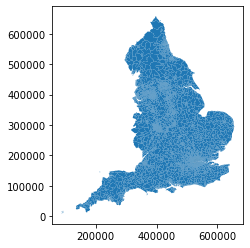

In [5]:
MSOA.plot()

## Get the centroid of MSOA (demand points)

In [6]:
MSOA_points=gpd.read_file('https://github.com/LingruFeng/dissertation/blob/main/data_github/England_basemap/MSOA_Population_Weighted_Centroids_with_population.gpkg?raw=true')
MSOA_points = MSOA_points.to_crs('epsg:27700')

<AxesSubplot:>

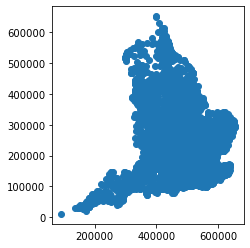

In [7]:
MSOA_points.plot()

### Calculate population over 70

In [8]:
MSOA_points['pop70+'] = MSOA_points['pop70-79'] + MSOA_points['pop80-89'] + MSOA_points['pop90+']

In [9]:
MSOA_points

,objectid,msoa11cd,pop0-49,pop50-59,pop60-69,pop70-79,pop80-89,pop90+,total_pop,geometry,pop70+
0,1,E02002536,5688,1416,1132,891,540,104,9771,POINT (445582.345 524175.434),1535
1,2,E02002537,5578,1251,836,545,386,45,8641,POINT (446777.151 524256.841),976
2,3,E02002534,2547,824,863,967,407,85,5693,POINT (461356.929 515118.900),1459
3,4,E02002535,4959,1636,1385,870,416,70,9336,POINT (446117.027 525455.836),1356
4,5,E02002532,3783,970,810,655,342,95,6655,POINT (461053.212 516175.379),1092
...,...,...,...,...,...,...,...,...,...,...,...
6786,6787,E02004669,3697,1171,1156,946,433,93,7496,POINT (393469.114 227500.260),1472
6787,6788,E02006096,3893,1086,805,804,344,69,7001,POINT (332829.367 109219.836),1217
6788,6789,E02003088,4007,1257,1230,1194,577,179,8444,POINT (343276.340 158947.520),1950
6789,6790,E02006070,5161,1163,906,670,316,75,8291,POINT (331710.269 136880.200),1061


## read vaccination site point data (supply points)

In [10]:
site = gpd.read_file('https://github.com/LingruFeng/dissertation/blob/main/data_github/site_2_26_clean/vaccination_site.gpkg?raw=true')
site = site.to_crs('epsg:27700')

<AxesSubplot:>

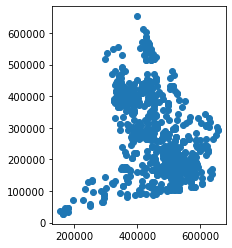

In [11]:
site.plot()

In [12]:
site

,index,supply_value,geometry
0,0,1,POINT (504748.029 248914.642)
1,1,1,POINT (505059.230 222903.988)
2,2,1,POINT (532504.110 176066.629)
3,3,1,POINT (532504.110 176066.629)
4,4,1,POINT (504396.617 222557.941)
...,...,...,...
1595,1595,1,POINT (196928.058 72385.978)
1596,1596,1,POINT (524814.936 172019.963)
1597,1597,1,POINT (526813.753 181129.037)
1598,1598,1,POINT (408626.628 90816.439)


There are 555158 pairs of distances that meet the requirement.

# Read in the driving distance from the point of demand to the point of supply as cost

In [13]:
distance_cost_df = pd.read_csv('https://raw.githubusercontent.com/LingruFeng/dissertation/main/data_github/distance_cost_final.csv') 
distance_cost_df = distance_cost_df.rename(columns={"Distance in meter": "cost", "origin_id": "origin", "destination_id": "dest"})
distance_cost_df

,cost,origin,dest
0,7681,E02002536,122
1,14506,E02002536,127
2,14764,E02002536,137
3,12744,E02002536,836
4,12605,E02002536,838
...,...,...,...
555153,15948,E02003088,1204
555154,7966,E02006070,1278
555155,21577,E02006679,1176
555156,10890,E02006679,1177


# Calculate the MSOAs that have no vaccination service within 10 miles distance and plot the map

In [117]:
# Get demand MSOAs that have at least one vaccination site within 10 miles of distance
distance_cost_df_test = distance_cost_df.loc[distance_cost_df['cost']<16093.44]
distance_cost_df_test

a = pd.unique(distance_cost_df_test['origin'])

# Set 'MSOA_with_supply' field True if a place has at least one vaccination site within 10 miles of distance, otherwise False.
b = pd.DataFrame()
b['MSOA'] = a
b['MSOA_with_supply'] = True

MSOA_with_supply = pd.merge(left = MSOA,right = b, how='left', left_on='MSOA11CD', right_on='MSOA')
MSOA_with_supply=MSOA_with_supply.fillna(False)

### Count the number of MSOAs that are lack of vaccination service

In [116]:
m = MSOA_with_supply[MSOA_with_supply['MSOA_with_supply']==False]
print('There are ',m['MSOA11CD'].count(),'MSOAs that are lack of vaccination service setting 10 miles as the vaccination service radius threshold.')

There are  381 MSOAs that are lack of vaccination service setting 10 miles as the vaccination service radius threshold.


### Plot the regions that are lack of service

In [ ]:
# Get the boundary of England
MSOA_with_supply['dissolve']=1
MSOA_outline = MSOA_with_supply.dissolve(by='dissolve')

Text(0.5, 1.0, 'MSOAs Lack of Vaccination Service')

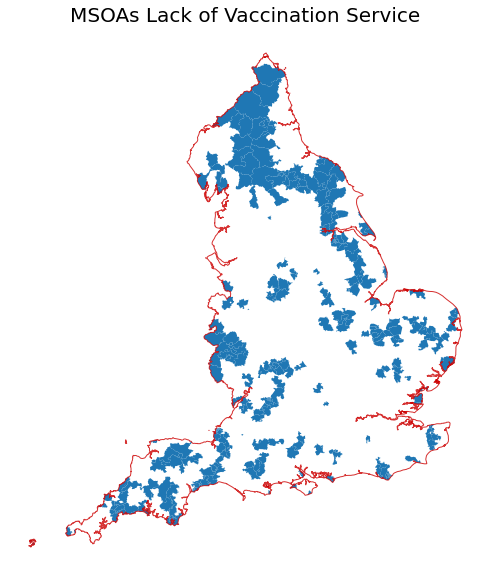

In [112]:
# Plot the map
f,ax = plt.subplots(figsize=(10,10))
m.plot(figsize = (10,10),ax=ax)
MSOA_outline.plot(edgecolor=(0.8, 0, 0,0.8), facecolor='none', linewidth=1,ax=ax)
ax.axis('off')
ax.set_title('MSOAs Lack of Vaccination Service', fontdict={'fontsize':'20', 'fontweight':'3'})

# Create a dataframe for the accessibility calculation using the Driving distance from the point of demand to the point of supply as cost

In [14]:
fca = access(demand_df = MSOA_points,
           demand_index='msoa11cd',
           demand_value='pop70+',
           supply_df= site,
           supply_index= 'index',
           supply_value=['supply_value'],
           cost_df              = distance_cost_df,
           cost_origin          = 'origin',
           cost_dest            = 'dest',
           cost_name            = 'cost',
           neighbor_cost_df     = distance_cost_df,
           neighbor_cost_origin = 'origin',
           neighbor_cost_dest   = 'dest',
           neighbor_cost_name   = 'cost')

### 2SFCA

In [15]:
# Using 2SFCA method, 16093.44 meters (10 miles) is used as service threshold radius to calculate the accessibility
fca.two_stage_fca(name = "2sfca",max_cost = 16093.44)

,2sfca_supply_value
msoa11cd,
E02000001,0.002246
E02000002,0.000393
E02000003,0.000372
E02000004,0.000264
E02000005,0.000375
...,...
E02006930,0.001504
E02006931,0.001633
E02006932,0.000164


### E2SFCA

#### Set distance decay weight using gaussian function.

In [16]:
# Define a gaussian weight. Here, set the σ to be 5364.48 (meters), which is one third of the threshold, such that we'll be at the 3σ level at 16093.44 meters.
# 用3σ原理解释参数的选择 (According to the the empirical rule, also referred to as the three-sigma rule,
# for a normal distribution, almost all observed data will fall within three standard deviations.因此当距离接近threshold时，weight趋近于0)
gaussian = weights.gaussian(sigma =5364.48)
gaussian

fca.enhanced_two_stage_fca(name = "E2sfca", weight_fn = gaussian)

,E2sfca_supply_value
msoa11cd,
E02000001,0.003549
E02000002,0.000337
E02000003,0.000341
E02000004,0.000243
E02000005,0.000398
...,...
E02006930,0.001400
E02006931,0.001472
E02006932,0.000120


### 3SFCA

In [17]:
fca.three_stage_fca(name = "3sfca", weight_fn = gaussian)

,3sfca_supply_value
msoa11cd,
E02000001,0.002930
E02000002,0.000358
E02000003,0.000356
E02000004,0.000264
E02000005,0.000419
...,...
E02006930,0.001330
E02006931,0.001417
E02006932,0.000091


### Rational agent access model (RAAM)

In [18]:
fca.raam(name = "raam", tau = 16093.44);

## See the result

In [19]:
fca.access_df

,pop70+,2sfca_supply_value,E2sfca_supply_value,3sfca_supply_value,raam_supply_value
msoa11cd,,,,,
E02000001,1151,0.002246,0.003549,0.002930,0.091903
E02000002,774,0.000393,0.000337,0.000358,0.957063
E02000003,954,0.000372,0.000341,0.000356,0.872137
E02000004,822,0.000264,0.000243,0.000264,1.039580
E02000005,677,0.000375,0.000398,0.000419,0.864767
...,...,...,...,...,...
E02006930,488,0.001504,0.001400,0.001330,0.402643
E02006931,843,0.001633,0.001472,0.001417,0.295616
E02006932,115,0.000164,0.000120,0.000091,2.412537


In [20]:
fca.access_df.describe()

,pop70+,2sfca_supply_value,E2sfca_supply_value,3sfca_supply_value,raam_supply_value
count,6791.000000,6410.000000,6.642000e+03,6.642000e+03,6642.000000
mean,1112.792814,0.000290,2.857202e-04,2.819871e-04,2.091828
std,445.710299,0.000458,5.162580e-04,4.707332e-04,1.073885
min,75.000000,0.000011,2.374329e-22,2.697153e-22,0.034615
25%,789.000000,0.000090,6.759050e-05,6.568615e-05,1.487120
50%,1065.000000,0.000134,1.305637e-04,1.289287e-04,2.079917
75%,1372.500000,0.000201,2.312855e-04,2.320700e-04,2.670109
max,3819.000000,0.002298,3.720282e-03,2.991003e-03,7.818210


# Show the accessibility/vaccination rate result on map

In [56]:
MSOA_fca = pd.merge(left=MSOA, right=fca.access_df, how='left', left_on='MSOA11CD', right_on='msoa11cd')
MSOA_fca=MSOA_fca.fillna(0)
MSOA_fca = MSOA_fca.rename(columns={"2sfca_supply_value": "2sfca", "E2sfca_supply_value": "E2sfca", 
                                    "3sfca_supply_value": "3sfca", "raam_supply_value": "raam"})

## Use min-max normalization to normalize the accessibility score

In [57]:
MSOA_fca['2sfca_normalized'] = (MSOA_fca['2sfca']-MSOA_fca['2sfca'].min())/(MSOA_fca['2sfca'].max()-MSOA_fca['2sfca'].min())
MSOA_fca['E2sfca_normalized'] = (MSOA_fca['E2sfca']-MSOA_fca['E2sfca'].min())/(MSOA_fca['E2sfca'].max()-MSOA_fca['E2sfca'].min())
MSOA_fca['3sfca_normalized'] = (MSOA_fca['3sfca']-MSOA_fca['3sfca'].min())/(MSOA_fca['3sfca'].max()-MSOA_fca['2sfca'].min())
MSOA_fca['raam_normalized'] = (MSOA_fca['raam']-MSOA_fca['raam'].min())/(MSOA_fca['raam'].max()-MSOA_fca['raam'].min())
MSOA_fca['raam_inverse_normalize'] = 1-MSOA_fca['raam_normalized']

In [61]:
# Read the population data
url = 'https://raw.githubusercontent.com/LingruFeng/dissertation/main/data_raw/vaccination_number_2020_12_8_2021_2_21.csv'
vaccination_pop = pd.read_csv(url)
vaccination_pop['over70'] = vaccination_pop['over70-74'] + vaccination_pop['over75-79'] + vaccination_pop['over80']

# merge the population data
MSOA_fca = pd.merge(left = MSOA_fca, right=vaccination_pop, how='left', left_on='MSOA11CD', right_on='MSOA_code')

# merge the LA information
MSOA_fca = pd.merge(left = MSOA_fca, right=LA_MSOA, how='left', left_on='MSOA11CD', right_on='MSOA Code')
MSOA_fca['vaccination_percentage_for70+'] = MSOA_fca['over70']/MSOA_fca['pop70+']

# Set vaccination rate greater than 1 to 1
MSOA_fca['vaccination_rate_70+']= np.where(MSOA_fca['vaccination_percentage_for70+']>1, 1, MSOA_fca['vaccination_percentage_for70+'])

In [62]:
# Subset the columns to only needed ones
MSOA_fca = MSOA_fca[['LA_Code_2020','LA_name_2020','MSOA11CD','MSOA11NM','pop70+','over70',
                     'vaccination_rate_70+',
                     '2sfca','2sfca_normalized',
                     'E2sfca','E2sfca_normalized',
                     '3sfca','3sfca_normalized',
                     'raam','raam_normalized','raam_inverse_normalize',
                     'geometry']]

## Map plot code

In [25]:
# for Accessibility (continuous)
def access(access_metric):
    base = MSOA_fca.plot(access_metric, legend = True, 
                         figsize = (10,10), 
                         cmap = "magma", 
                         markersize = .5, 
                         alpha = 1,
                         vmin = MSOA_fca[access_metric].quantile(0.05), vmax = MSOA_fca[access_metric].quantile(0.95))
    base.axis('off')
    base.set_title('England Vaccination Accessibility', fontdict={'fontsize':'20', 'fontweight':'3'})

In [26]:
# for Accessibility (natural break)
def access_break(column):
    f,ax = plt.subplots(figsize=(10,10))
    MSOA_fca.plot(ax=ax,column=column, edgecolor='None',
              scheme='NaturalBreaks',k=7,legend=True)
    ax.axis('off') 
    ax.set_title('England Vaccination Accessibility', fontdict={'fontsize':'20', 'fontweight':'3'})

    ax.get_legend().set_title("Accessbility")

    q = mc.NaturalBreaks(MSOA_fca[column], k=7)
    legendgram(f, ax, 
                MSOA_fca[column], q.bins, bins=20,
                pal=palmpl.Viridis_7,
                legend_size=(0.5, 0.12), 
                loc='lower right',
                #clip=(0,100),
                frameon=False)

In [27]:
# for Vaccination Rate (continuous)
def pop_rate(access_metric):
    base = MSOA_fca.plot(access_metric, legend = True, 
                         figsize = (10,10), 
                         cmap = "magma", 
                         markersize = .5, 
                         alpha = 1,
                         vmin = MSOA_fca[access_metric].quantile(0.05), vmax = MSOA_fca[access_metric].quantile(0.95))
    base.axis('off')
    base.set_title('England Vaccination Rate in over 70s by MSOA', fontdict={'fontsize':'20', 'fontweight':'3'})
    #site.plot(ax=base, markersize=1, color='red')

In [28]:
# for Vaccination Rate (natural break)
def pop_rate_break(column):
    f,ax = plt.subplots(figsize=(10,10))
    MSOA_fca.plot(ax=ax,column=column, edgecolor='None',
              scheme='NaturalBreaks',k=7,legend=True)
    ax.axis('off') 
    ax.set_title('England Vaccination Rate in over 70s by MSOA', fontdict={'fontsize':'20', 'fontweight':'3'})

    ax.get_legend().set_title("Vaccination Rate")

    q = mc.NaturalBreaks(MSOA_fca[column], k=7)
    legendgram(f, ax, 
                MSOA_fca[column], q.bins, bins=20,
                pal=palmpl.Viridis_7,
                legend_size=(0.5, 0.12), 
                loc='lower right',
                #clip=(0,100),
                frameon=False)

In [29]:
# Get the London boundary map for more conplex map plot 
# Read some London Boundary data for map show
# An intricate map of London's borders
borough = gpd.read_file('https://github.com/LingruFeng/0006_DSSS_assessment/blob/main/London_Boroughs.gpkg?raw=true')
borough = borough.to_crs('epsg:27700')
London = pd.merge(left = MSOA_fca, right=borough[['gss_code','objectid']],how = 'left', left_on='LA_Code_2020', right_on='gss_code')
London = London.dropna()
London['London'] = 'London'
London_boundary = London.dissolve(by='London')

# A rough map of the borders of London
inner=gpd.read_file('https://github.com/LingruFeng/i2p_assessment3/blob/main/inner_outer.gpkg?raw=true')
inner = inner.to_crs('epsg:27700')
inner = inner.dissolve(by='Source')

In [30]:
# for Vaccination Rate (break) with London zooming in
def pop_rate_break_1(column):
    f,ax = plt.subplots(figsize=(13,13))
    MSOA_fca.plot(ax=ax,column=column, edgecolor='None',
              scheme='NaturalBreaks',k=7,legend=True)
    inner.plot(edgecolor=(0.8, 0, 0,0.8), facecolor='none', linewidth=1, ax=ax)
    ax.axis('off') 
    ax.set_title('England Vaccination Rate in over 70s by MSOA', fontdict={'fontsize':'20', 'fontweight':'3'})
    
    ax.get_legend().set_title("Vaccination Rate")
    ax.get_legend().get_title().set_fontsize('15')
    
    ax.text(x=140000, y=590000, s='N', fontsize=30)
    ax.arrow(150000, 530000, 0, 60000, length_includes_head=True,
          head_width=20000, head_length=80000, overhang=.1, facecolor='k')
    
    ax2 = f.add_axes([0.1, 0.35, 0.3, 0.3])
    MSOA_fca.plot(column=column,edgecolor='None', scheme='NaturalBreaks',k=7,legend=False,ax=ax2)
    ax2.set_xlim([502300,562800])
    ax2.set_ylim([154800,201800])
    ax2.set_title('London', fontdict={'fontsize':'20', 'fontweight':'3'})
    London_boundary.plot(edgecolor=(0.8, 0, 0,0.8), facecolor='none', linewidth=1, ax=ax2)
    ax2.axis('off')

    q = mc.NaturalBreaks(MSOA_fca[column], k=7)
    legendgram(f, ax, 
                MSOA_fca[column], q.bins, bins=20,
                pal=palmpl.Viridis_7,
                legend_size=(0.5, 0.12), 
                loc='lower right',
                #clip=(0,100),
                frameon=False)

In [31]:
# for Vaccination accessibility (break) with London zooming in
def access_break_1(column):
    f,ax = plt.subplots(figsize=(13,13))
    MSOA_fca.plot(ax=ax,column=column, edgecolor='None',
              scheme='NaturalBreaks',k=7,legend=True)
    inner.plot(edgecolor=(0.8, 0, 0,0.8), facecolor='none', linewidth=1, ax=ax)
    ax.axis('off') 
    ax.set_title('England Vaccination Accessibility in over 70s by MSOA', fontdict={'fontsize':'20', 'fontweight':'3'})
    
    ax.get_legend().set_title("Accessibility")
    ax.get_legend().get_title().set_fontsize('15')
    
    ax.text(x=140000, y=590000, s='N', fontsize=30)
    ax.arrow(150000, 530000, 0, 60000, length_includes_head=True,
          head_width=20000, head_length=80000, overhang=.1, facecolor='k')
    
    ax2 = f.add_axes([0.1, 0.35, 0.3, 0.3])
    MSOA_fca.plot(column=column,edgecolor='None', scheme='NaturalBreaks',k=7,legend=False,ax=ax2)
    ax2.set_xlim([502300,562800])
    ax2.set_ylim([154800,201800])
    ax2.set_title('London', fontdict={'fontsize':'20', 'fontweight':'3'})
    London_boundary.plot(edgecolor=(0.8, 0, 0,0.8), facecolor='none', linewidth=1, ax=ax2)
    ax2.axis('off')

    q = mc.NaturalBreaks(MSOA_fca[column], k=7)
    legendgram(f, ax, 
                MSOA_fca[column], q.bins, bins=20,
                pal=palmpl.Viridis_7,
                legend_size=(0.5, 0.12), 
                loc='lower right',
                #clip=(0,100),
                frameon=False)

In [32]:
# for London Vaccination Rate map only
def pop_rate_break_London(column):
    f,ax = plt.subplots(figsize=(10,10))
    London.plot(ax=ax,column=column, edgecolor='None',
              scheme='NaturalBreaks',k=7,legend=True)
    ax.axis('off') 
    ax.set_title('London Vaccination Rate in over 70s by MSOA', fontdict={'fontsize':'20', 'fontweight':'3'})

    ax.get_legend().set_title("Vaccination Rate")

    q = mc.NaturalBreaks(London[column], k=7)
    legendgram(f, ax, 
                London[column], q.bins, bins=20,
                pal=palmpl.Viridis_7,
                legend_size=(0.5, 0.12), 
                loc='lower right',
                #clip=(0,100),
                frameon=False)

In [33]:
# for London accessibility map only
def access_break_London(column):
    f,ax = plt.subplots(figsize=(10,10))
    London.plot(ax=ax,column=column, edgecolor='None',
              scheme='NaturalBreaks',k=7,legend=True)
    ax.axis('off') 
    ax.set_title('London Vaccination Accessibility in over 70s by MSOA', fontdict={'fontsize':'20', 'fontweight':'3'})

    ax.get_legend().set_title("Accessibility")

    q = mc.NaturalBreaks(London[column], k=7)
    legendgram(f, ax, 
                London[column], q.bins, bins=20,
                pal=palmpl.Viridis_7,
                legend_size=(0.5, 0.12), 
                loc='lower right',
                #clip=(0,100),
                frameon=False)

## Accessibility (When the service radius is 10 miles driving distance)

### 2SFCA

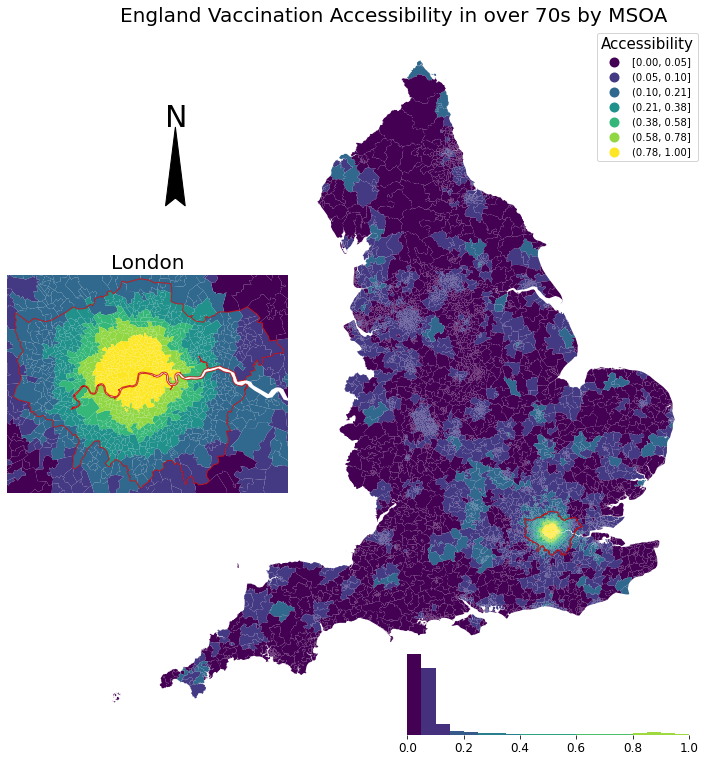

In [34]:
access_break_1('2sfca_normalized')

### E2SFCA

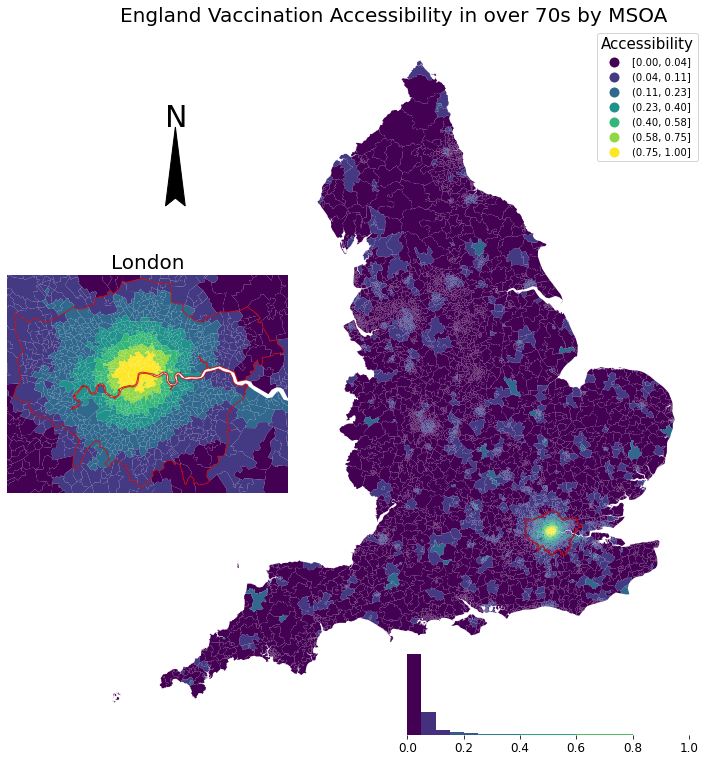

In [35]:
access_break_1('E2sfca_normalized')

### 3SFCA

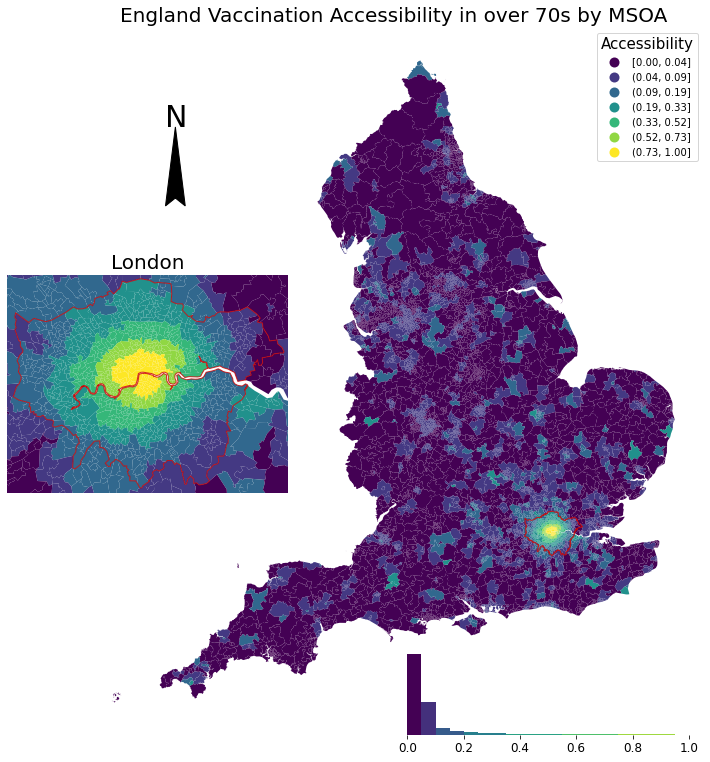

In [36]:
access_break_1('3sfca_normalized')

### RAAM

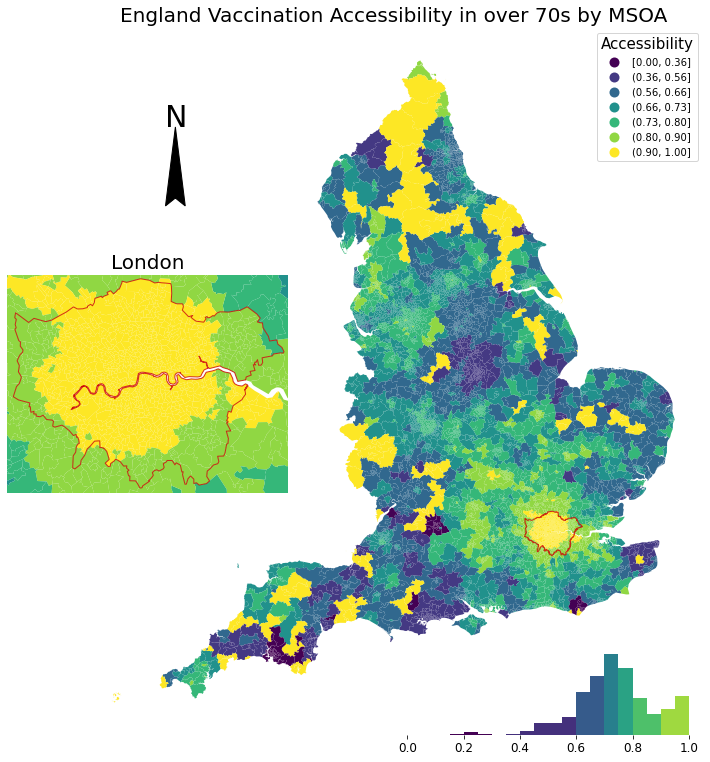

In [64]:
access_break_1('raam_inverse_normalize')

## Vaccination Rate

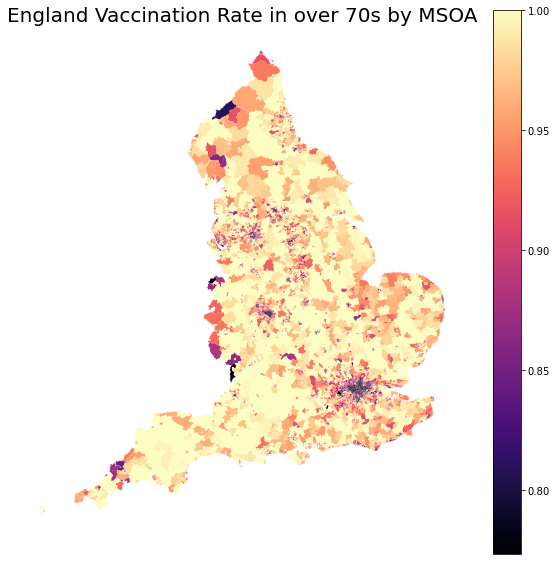

In [38]:
pop_rate('vaccination_rate_70+')

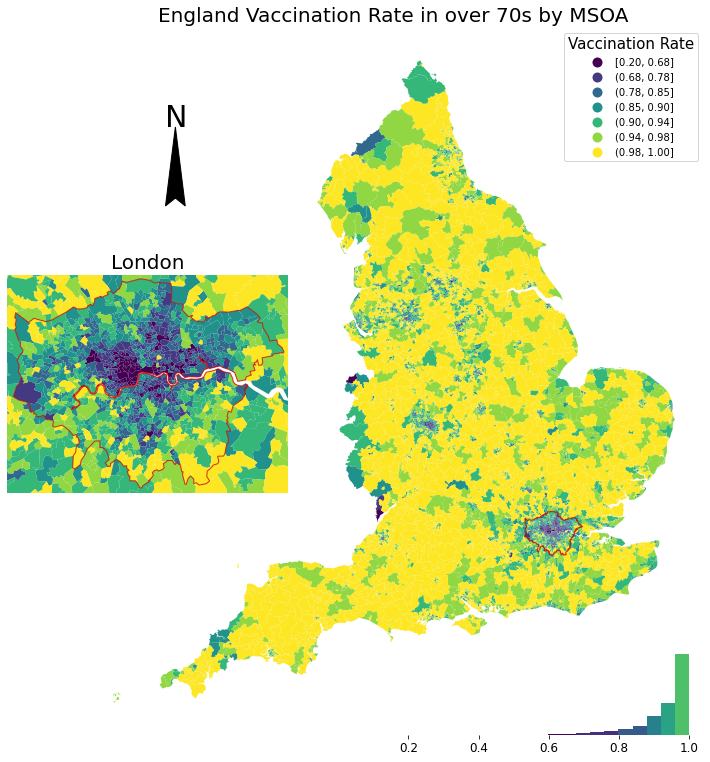

In [39]:
pop_rate_break_1('vaccination_rate_70+')

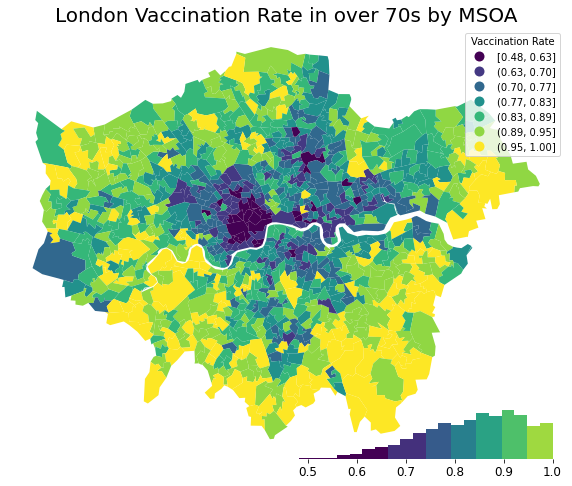

In [40]:
pop_rate_break_London('vaccination_rate_70+')

# Calculate Pearson and Spearman correlation coefficient of accessibility and vaccination rate

### 2SFCA

In [41]:
print('Pearson correlation coefficient:',stats.pearsonr(MSOA_fca['2sfca_normalized'], MSOA_fca['vaccination_rate_70+'])[0])
print('p-value:', stats.pearsonr(MSOA_fca['2sfca_normalized'], MSOA_fca['vaccination_rate_70+'])[1])

Pearson correlation coefficient: -0.6238306671241038
p-value: 0.0


In [42]:
print('Spearman correlation coefficient:',stats.spearmanr(MSOA_fca['2sfca_normalized'], MSOA_fca['vaccination_rate_70+'])[0])
print('p-value:', stats.spearmanr(MSOA_fca['2sfca_normalized'], MSOA_fca['vaccination_rate_70+'])[1])

Spearman correlation coefficient: -0.352876054951216
p-value: 2.456024715846902e-198


### E2SFCA

In [43]:
print('Pearson correlation coefficient:',stats.pearsonr(MSOA_fca['E2sfca_normalized'], MSOA_fca['vaccination_rate_70+'])[0])
print('p-value:', stats.pearsonr(MSOA_fca['E2sfca_normalized'], MSOA_fca['vaccination_rate_70+'])[1])

Pearson correlation coefficient: -0.6262473804570674
p-value: 0.0


In [44]:
print('Spearman correlation coefficient:',stats.spearmanr(MSOA_fca['E2sfca_normalized'], MSOA_fca['vaccination_rate_70+'])[0])
print('p-value:', stats.spearmanr(MSOA_fca['E2sfca_normalized'], MSOA_fca['vaccination_rate_70+'])[1])

Spearman correlation coefficient: -0.39877820201197267
p-value: 1.1555632138574016e-257


### 3SFCA

In [45]:
print('Pearson correlation coefficient:',stats.pearsonr(MSOA_fca['3sfca_normalized'], MSOA_fca['vaccination_rate_70+'])[0])
print('p-value:', stats.pearsonr(MSOA_fca['3sfca_normalized'], MSOA_fca['vaccination_rate_70+'])[1])

Pearson correlation coefficient: -0.6353868792171563
p-value: 0.0


In [46]:
print('Spearman correlation coefficient:',stats.spearmanr(MSOA_fca['3sfca_normalized'], MSOA_fca['vaccination_rate_70+'])[0])
print('p-value:', stats.spearmanr(MSOA_fca['3sfca_normalized'], MSOA_fca['vaccination_rate_70+'])[1])

Spearman correlation coefficient: -0.3782988445245684
p-value: 5.2716025619612455e-230


### RAAM

In [65]:
print('Pearson correlation coefficient:',stats.pearsonr(MSOA_fca['raam_inverse_normalize'], MSOA_fca['vaccination_rate_70+'])[0])
print('p-value:', stats.pearsonr(MSOA_fca['raam_inverse_normalize'], MSOA_fca['vaccination_rate_70+'])[1])

Pearson correlation coefficient: -0.3937824935525908
p-value: 9.833700242031282e-251


In [66]:
print('Spearman correlation coefficient:',stats.spearmanr(MSOA_fca['raam_inverse_normalize'], MSOA_fca['vaccination_rate_70+'])[0])
print('p-value:', stats.spearmanr(MSOA_fca['raam_inverse_normalize'], MSOA_fca['vaccination_rate_70+'])[1])

Spearman correlation coefficient: -0.33065516416887486
p-value: 5.9592316152675694e-173


# draw a scatter plot between accessibility and vaccination rate

In [49]:
def scatter_plot(accesstype):
    plot = pd.DataFrame()
    plot['Accessibility'] = MSOA_fca[accesstype]
    plot['Vaccination Rate'] = MSOA_fca['vaccination_rate_70+']
    plt.style.use('ggplot')
    plt.figure(figsize=(10, 6))
    a = sns.scatterplot(data=plot, x="Accessibility", y="Vaccination Rate",s=10)
    a.axes.set_title("Scatter Plot Between Accessibility and Vaccination Rate",fontsize=20)
    a.set_xlabel("Accessibility",fontsize=15)
    a.set_ylabel("Vaccination Rate",fontsize=+15)

In [50]:
def pair(accesstype):
    plot = pd.DataFrame()
    plot['Accessibility'] = MSOA_fca[accesstype]
    plot['Vaccination Rate'] = MSOA_fca['vaccination_rate_70+']
    g = sns.pairplot(plot,plot_kws={"s": 10})
    g.fig.set_size_inches(10,7)
    g.fig.suptitle("Pair Plot Between Accessibility and Vaccination Rate", y=1.05,x=0.55,fontsize=20)

### 2SFCA

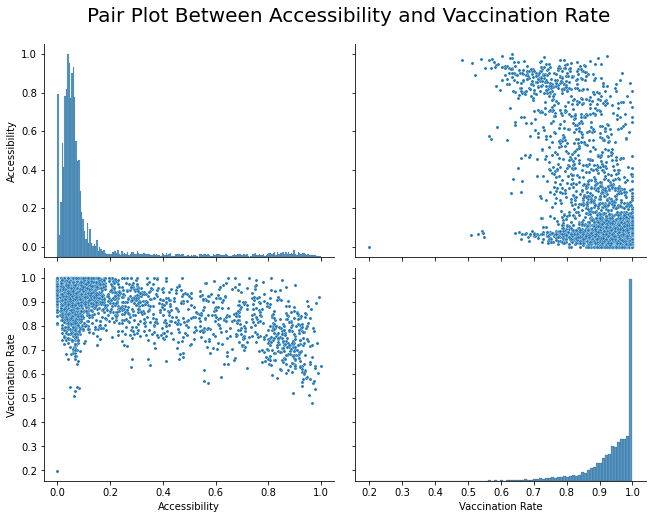

In [51]:
pair('2sfca_normalized')

### E2SFCA

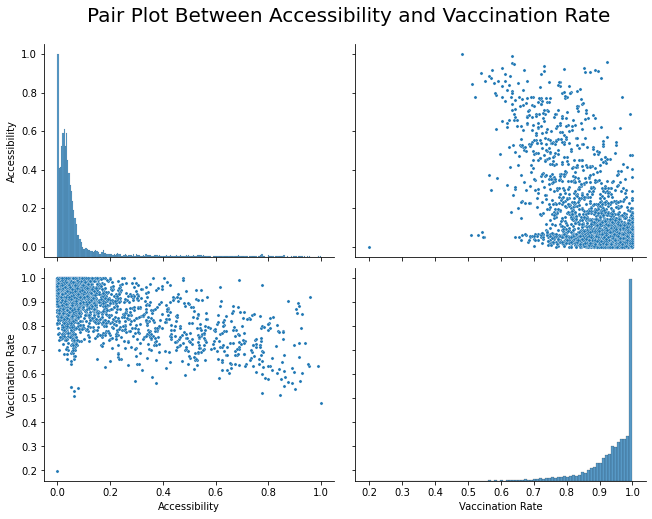

In [52]:
pair('E2sfca_normalized')

### 3SFCA

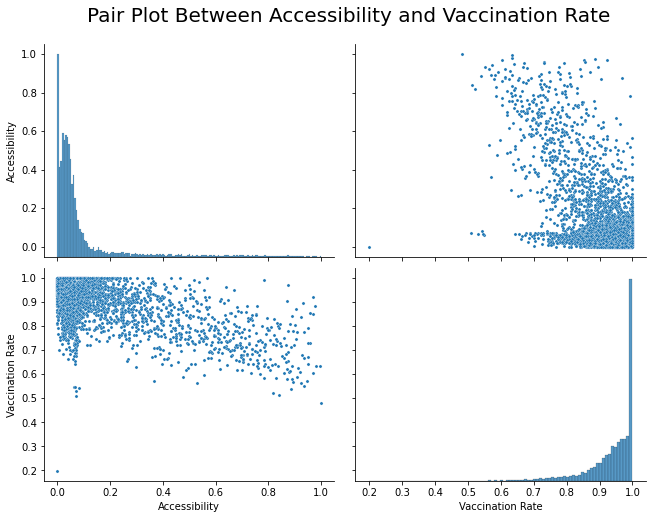

In [53]:
pair('3sfca_normalized')

### RAAM

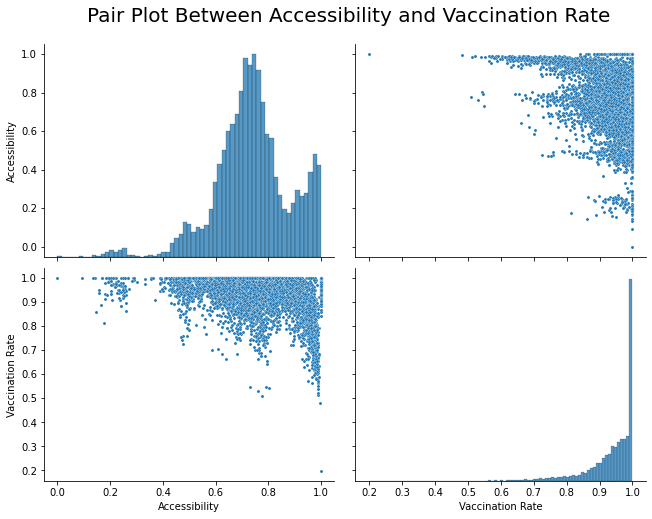

In [67]:
pair('raam_inverse_normalize')

In [55]:
#ax1 = plot.plot.scatter(x='Accessibility',
#                        y='Vaccination Rate',
#                        figsize = (10,6),
#                        fontsize = 15,s=10)
#plt.title("Scatter Plot between Accessibility and Vaccination Rate",fontsize=20)
#plt.xlabel("Accessibility",fontsize=15)
#plt.ylabel("Vaccination Rate",fontsize=15)